In [1]:
import numpy as np
from scipy.io import loadmat

import os

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Blues'

import seaborn as sns

import tikzplotlib

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    return onehot.cumsum(axis=time_axis)


policies = [
    'classical ens',
    # 'round robin greedy',
    'greedy',
    'ens jensen greedy'
]
names = [
    'ENS',
    # 'RR-Greedy',
    'One-step',
    'D-ENS'
]
assert len(policies) == len(names)

# postfix = '0.33 corners'
postfix = 'equal radius'
budget = 100

# postfix = 'budget 50'
# budget = 50

n_exps = 20
n_classes = 6
class_names = ['center', 'corner1', 'corner2', 'corner3', 'corner4']
init_size = 1

group_size = n_classes - 1

basepath = os.path.join('../../data/results/square', str(group_size) + ' ' + postfix)


queried_xs = np.ones((len(policies), n_exps, init_size + budget, 2)) * -1
class_counts = -1 * np.ones(
    (len(policies), n_exps, init_size + budget, n_classes), dtype=int
)

for p_ind, policy in enumerate(policies):
    for i in range(n_exps):
        queries = np.loadtxt(
            os.path.join(basepath, policy, f'{policy}__ind__{i + 1}.csv'),
            dtype=int
        ).flatten() - 1
        
        xs = loadmat(
            f'../../data/square/square_nearest_neighbors_{i + 1}.mat'
        )['x']
        
        queried_xs[p_ind, i, :, :] = xs[queries, :]
        
        labels = np.loadtxt(
            os.path.join(basepath, policy, f'{policy}__labels__{i + 1}.csv'), 
            dtype=int
        ).flatten() - 1
        
        class_counts[p_ind, i, :] = labels_to_counts(labels)
        
assert np.all(queried_xs != -1)
assert np.all(class_counts != -1)

In [3]:
grid_size = 100
multiplier = 25

counts = np.zeros((len(policies), grid_size, grid_size))
for p_ind in range(len(policies)):
    flat_queried_xs = queried_xs[p_ind, :, :, :].reshape(-1, 2)
    
    for point in flat_queried_xs:
        x_coor = int(point[0] * grid_size)
        y_coor = int(point[1] * grid_size)

        counts[p_ind, x_coor, y_coor] += 1
        
counts *= multiplier

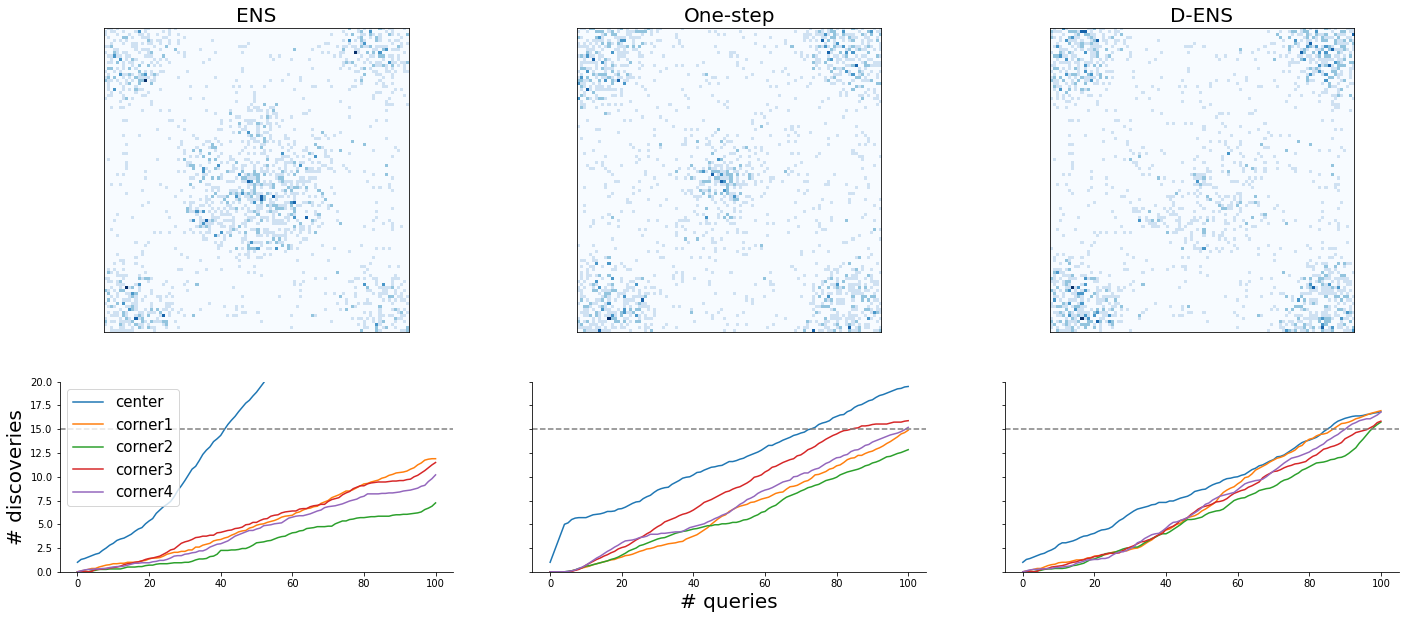

In [4]:
fontsize = 20

cutoff = 15

fig, ax = plt.subplots( 
    2,
    len(policies),
    figsize=(8 * len(policies), 10),
    gridspec_kw={'height_ratios': [1.6, 1]},
    sharey="row"
)

xs = np.linspace(0, 1, 101)
x1, x2 = np.meshgrid(xs, xs, indexing="ij")
xs = np.vstack([x1.flatten(), x2.flatten()]).T


def distance(xs, point):
    return np.sqrt(
        (
            xs - point
        ) ** 2
    )


true_pdfs = np.ones(101 ** 2)
clusters = [
    (np.array([0.5, 0.5]), 0.25, 0.5),
    (np.array([0., 0.]), 0.25, 1),
    (np.array([0., 1.]), 0.25, 1),
    (np.array([1., 0.]), 0.25, 1),
    (np.array([1., 1.]), 0.25, 1),
]
for cluster, radius, rate in clusters:
    distances = np.sqrt(((xs - cluster) ** 2).sum(axis=1))
    mask = distances < radius
    true_pdfs[mask] = rate

for i, (policy, name) in enumerate(zip(policies, names)):
    ax[0, i].imshow(counts[i], origin="lower", extent=[0, 1, 0, 1])
    
    ax[0, i].set_xlim(0, 1)
    ax[0, i].set_ylim(0, 1)
    ax[0, i].set_xticklabels([])
    ax[0, i].set_xticks([])
    ax[0, i].set_yticklabels([])
    ax[0, i].set_yticks([])
    ax[0, i].set_aspect('equal', 'box')
    
    for c in range(1, n_classes):
        ax[1, i].plot(
            class_counts[i, :, :, c].mean(axis=0),
            c=f"C{c - 1}",
            label=class_names[c - 1]
        )
    
    ax[0, i].set_title(name, fontsize=fontsize)
    # ax[1, i].set_xlabel("# queries", fontsize=fontsize)
    ax[1, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].axhline(cutoff, c="gray", linestyle="--")

ax[1, len(policies) // 2].set_xlabel("# queries", fontsize=fontsize)
ax[1, 0].set_ylabel("# discoveries", fontsize=fontsize)
ax[1, 0].set_ylim((0, 20))
ax[1, 0].legend(loc="upper left", fontsize=15)

plt.show()
# tikzplotlib.save("square.tex")

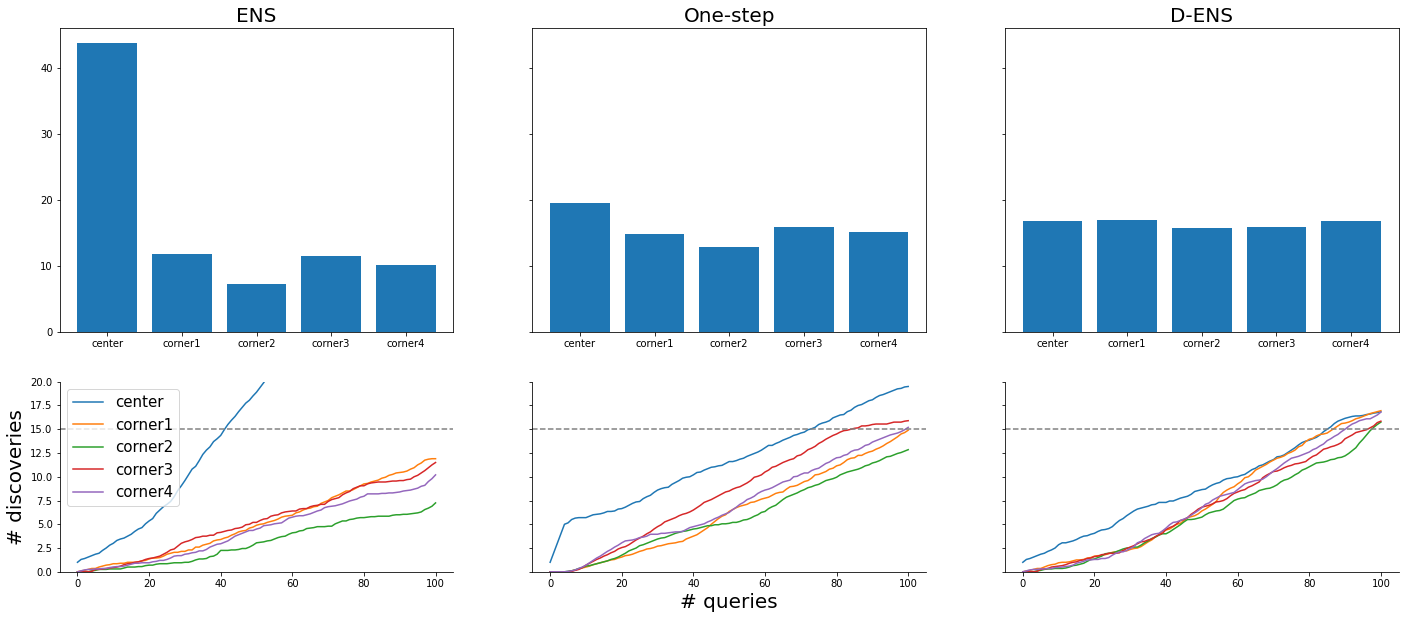

In [5]:
fontsize = 20

cutoff = 15

fig, ax = plt.subplots( 
    2,
    len(policies),
    figsize=(8 * len(policies), 10),
    gridspec_kw={'height_ratios': [1.6, 1]},
    sharey="row"
)

xs = np.linspace(0, 1, 101)
x1, x2 = np.meshgrid(xs, xs, indexing="ij")
xs = np.vstack([x1.flatten(), x2.flatten()]).T


def distance(xs, point):
    return np.sqrt(
        (
            xs - point
        ) ** 2
    )


true_pdfs = np.ones(101 ** 2)
clusters = [
    (np.array([0.5, 0.5]), 0.25, 0.5),
    (np.array([0., 0.]), 0.25, 1),
    (np.array([0., 1.]), 0.25, 1),
    (np.array([1., 0.]), 0.25, 1),
    (np.array([1., 1.]), 0.25, 1),
]
for cluster, radius, rate in clusters:
    distances = np.sqrt(((xs - cluster) ** 2).sum(axis=1))
    mask = distances < radius
    true_pdfs[mask] = rate

for i, (policy, name) in enumerate(zip(policies, names)):
    ax[0, i].bar(
        np.arange(n_classes - 1), 
        class_counts[i, :, -1, :].mean(axis=0)[1:],
        tick_label=class_names
    )
    
    for c in range(1, n_classes):
        ax[1, i].plot(
            class_counts[i, :, :, c].mean(axis=0),
            c=f"C{c - 1}",
            label=class_names[c - 1]
        )
    
    ax[0, i].set_title(name, fontsize=fontsize)
    # ax[1, i].set_xlabel("# queries", fontsize=fontsize)
    ax[1, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].axhline(cutoff, c="gray", linestyle="--")

ax[1, len(policies) // 2].set_xlabel("# queries", fontsize=fontsize)
ax[1, 0].set_ylabel("# discoveries", fontsize=fontsize)
ax[1, 0].set_ylim((0, 20))
ax[1, 0].legend(loc="upper left", fontsize=15)

plt.show()
# tikzplotlib.save("square.tex")

In [6]:
from matplotlib import cm
from matplotlib.colors import Normalize

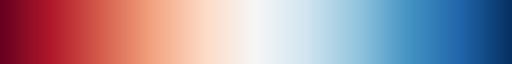

In [7]:
cmap = plt.get_cmap("RdBu")
cmap

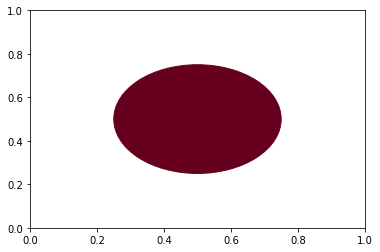

In [6]:
fig, ax = plt.subplots()

ax.add_patch(plt.Circle((0.5, 0.5), 0.25, color=cmap(0)))

plt.show()

In [4]:
from math import pi

classical ens 1 1.599009900990099
classical ens 1 536
classical ens 2 -0.293069306930693
classical ens 2 51
classical ens 3 -0.5693069306930693
classical ens 3 -18
classical ens 4 -0.3168316831683168
classical ens 4 45
classical ens 5 -0.3940594059405941
classical ens 5 26
greedy 1 0.1584158415841585
greedy 1 167
greedy 2 -0.11485148514851477
greedy 2 97
greedy 3 -0.2366336633663366
greedy 3 66
greedy 4 -0.055445544554455356
greedy 4 112
greedy 5 -0.097029702970297
greedy 5 102
ens jensen greedy 1 0.000990099009901145
ens jensen greedy 1 127
ens jensen greedy 2 0.006930693069306959
ens jensen greedy 2 128
ens jensen greedy 3 -0.06435643564356429
ens jensen greedy 3 110
ens jensen greedy 4 -0.05841584158415837
ens jensen greedy 4 112
ens jensen greedy 5 -0.001980198019801868
ens jensen greedy 5 126


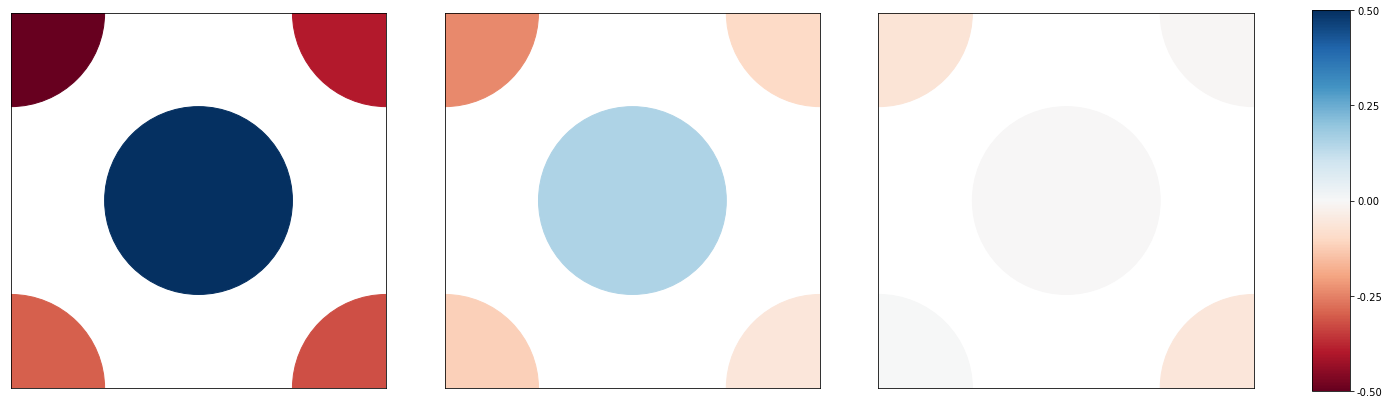

In [8]:
fontsize = 20

cutoff = 15

fig, ax = plt.subplots( 
    1,
    len(policies) + 1,
    figsize=(8 * len(policies), 7),
    gridspec_kw={'width_ratios': [5, 5, 5, 0.5]}
)

xs = np.linspace(0, 1, 101)
x1, x2 = np.meshgrid(xs, xs, indexing="ij")
xs = np.vstack([x1.flatten(), x2.flatten()]).T


def distance(xs, point):
    return np.sqrt(
        (
            xs - point
        ) ** 2
    )


true_pdfs = np.ones(101 ** 2)
clusters = [
    (np.array([0.5, 0.5]), 0.25, 0.5),
    (np.array([0., 0.]), 0.25, 1),
    (np.array([0., 1.]), 0.25, 1),
    (np.array([1., 0.]), 0.25, 1),
    (np.array([1., 1.]), 0.25, 1),
]
for cluster, radius, rate in clusters:
    distances = np.sqrt(((xs - cluster) ** 2).sum(axis=1))
    mask = distances < radius
    true_pdfs[mask] = rate
    
expected_uniform_counts = [pi / 16, pi / 64, pi / 64, pi / 64, pi / 64]

for i, (policy, name) in enumerate(zip(policies, names)):
    for c in range(1, n_classes):
#         value = int(
#             (
#                 class_counts[i, :, -1, c].mean(axis=0) 
#                 - class_counts[i, :, -1, :].mean()
#             ) 
#             / budget 
#             * 256 
#             * 16
#             + 127
#         )
        
#         value = np.log(
#             class_counts[i, :, -1, c].mean(axis=0) 
#             / class_counts[i, :, -1, :].mean()
#         )
#         value = value * 256 + 127
#         value = int(value)

        value = (
            class_counts[i, :, -1, c].mean(axis=0) 
            - class_counts[i, :, -1, :].mean()
        ) / class_counts[i, :, -1, :].mean()
        print(policy, c, value)
    
        value = int(value * 256 + 127)
    
        print(policy, c, value)
        
        ax[i].add_patch(
            plt.Circle(
                clusters[c - 1][0], 
                clusters[c - 1][1], 
                color=cmap(value)[:3]
            )
        )
    
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 1)
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticklabels([])
    ax[i].set_yticks([])
    ax[i].set_aspect('equal', 'box')
    
    # ax[i].set_title(name, fontsize=fontsize)

cbar = fig.colorbar(
    cm.ScalarMappable(cmap=cmap),
    cax=ax[-1],
    orientation="vertical",
    # label="increase from mean",
    ticks=np.array([0., 0.25, 0.5, 0.75, 1.])
    # ticks=[f"{(x - 127) / 256:.1f}" for x in [0, 0.2, 0.4, 0.6, 1]]
)
cbar.ax.set_yticklabels([f"{(x * 256 - 127) / 256:.2f}" for x in [0., 0.25, 0.5, 0.75, 1.]])

plt.show()
# tikzplotlib.save("square.tex")

In [11]:
from matplotlib.transforms import Bbox

In [38]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = []
    # items += ax.get_xticklabels() + ax.get_yticklabels() 
    # items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    # items += [ax, ax.title]
    items += [ax]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)


extent = full_extent(ax[3], pad=0.1).transformed(fig.dpi_scale_trans.inverted())
extent

Bbox([[21.052173913043482, 0.6107499999999998], [21.62608695652174, 6.42425]])

In [37]:
fig.savefig(f"{names[2]}.png", bbox_inches=extent)

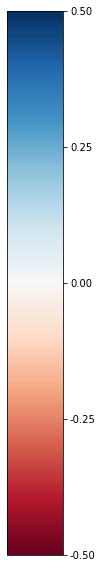

In [44]:
fig, ax = plt.subplots(figsize=(1, 10))

cbar = fig.colorbar(
    cm.ScalarMappable(cmap=cmap),
    cax=ax,
    orientation="vertical",
    # label="increase from mean",
    ticks=np.array([0., 0.25, 0.5, 0.75, 1.])
    # ticks=[f"{(x - 127) / 256:.1f}" for x in [0, 0.2, 0.4, 0.6, 1]]
)
cbar.ax.set_yticklabels([f"{(x * 256 - 127) / 256:.2f}" for x in [0., 0.25, 0.5, 0.75, 1.]])

# plt.show()
tikzplotlib.save("colorbar.tex")

In [ ]:
for i, (policy, name) in enumerate(zip(policies, names)):
    fig, ax = plt.subplots()
    
    for c in range(1, n_classes):
        value = (
            class_counts[i, :, -1, c].mean(axis=0) 
            - class_counts[i, :, -1, :].mean()
        ) / class_counts[i, :, -1, :].mean()
        value = int(value * 256 + 127)
    
        print(policy, c, value)
        
        ax[i].add_patch(
            plt.Circle(
                clusters[c - 1][0], 
                clusters[c - 1][1], 
                color=cmap(value)[:3]
            )
        )
    
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 1)
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticklabels([])
    ax[i].set_yticks([])
    ax[i].set_aspect('equal', 'box')

classical ens 1 371
classical ens 2 38
classical ens 3 -88
classical ens 4 29
classical ens 5 -1
greedy 1 164
greedy 2 95
greedy 3 57
greedy 4 112
greedy 5 100
ens jensen greedy 1 127
ens jensen greedy 2 128
ens jensen greedy 3 109
ens jensen greedy 4 111
ens jensen greedy 5 126


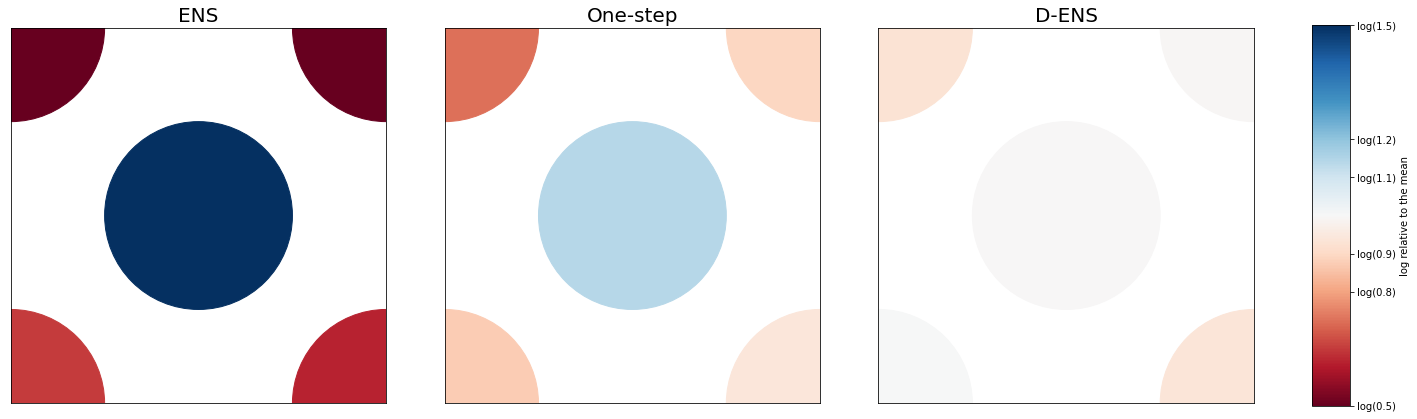

In [39]:
fontsize = 20

cutoff = 15

fig, ax = plt.subplots( 
    1,
    len(policies) + 1,
    figsize=(8 * len(policies), 7),
    gridspec_kw={'width_ratios': [5, 5, 5, 0.5]}
)

xs = np.linspace(0, 1, 101)
x1, x2 = np.meshgrid(xs, xs, indexing="ij")
xs = np.vstack([x1.flatten(), x2.flatten()]).T


def distance(xs, point):
    return np.sqrt(
        (
            xs - point
        ) ** 2
    )


true_pdfs = np.ones(101 ** 2)
clusters = [
    (np.array([0.5, 0.5]), 0.25, 0.5),
    (np.array([0., 0.]), 0.25, 1),
    (np.array([0., 1.]), 0.25, 1),
    (np.array([1., 0.]), 0.25, 1),
    (np.array([1., 1.]), 0.25, 1),
]
for cluster, radius, rate in clusters:
    distances = np.sqrt(((xs - cluster) ** 2).sum(axis=1))
    mask = distances < radius
    true_pdfs[mask] = rate
    
expected_uniform_counts = [pi / 16, pi / 64, pi / 64, pi / 64, pi / 64]

for i, (policy, name) in enumerate(zip(policies, names)):
    for c in range(1, n_classes):
        value = np.log(
            class_counts[i, :, -1, c].mean(axis=0) 
            / class_counts[i, :, -1, :].mean()
        )
        value = value * 256 + 127
        value = int(value)
    
        print(policy, c, value)
        
        ax[i].add_patch(
            plt.Circle(
                clusters[c - 1][0], 
                clusters[c - 1][1], 
                color=cmap(value)[:3]
            )
        )
    
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 1)
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticklabels([])
    ax[i].set_yticks([])
    ax[i].set_aspect('equal', 'box')
                 
    ax[i].set_title(name, fontsize=fontsize)

ticks = np.log(np.array([0.5, 0.8, 0.9, 1.1, 1.2, 1.5]))

cbar = fig.colorbar(
    cm.ScalarMappable(cmap=cmap),
    cax=ax[-1],
    orientation="vertical",
    label="log relative to the mean",
    ticks=np.exp(ticks) - 0.5
    # ticks=[f"{(x - 127) / 256:.1f}" for x in [0, 0.2, 0.4, 0.6, 1]]
)
cbar.ax.set_yticklabels([f"log({x})" for x in np.exp(ticks)])

plt.show()
# tikzplotlib.save("square.tex")

In [45]:
np.log(1.1), np.log(1.28), np.log(1.5)

(0.09531017980432493, 0.2468600779315258, 0.4054651081081644)

In [15]:
np.log(1.5), np.log(0.5)

(0.4054651081081644, -0.6931471805599453)

In [91]:
for p_ind, name in enumerate(policies):
    mean = class_counts[p_ind, :, -1, 1:].mean()
    
    print(name)
    print((class_counts[p_ind, :, -1, 1:].mean(axis=0) - mean) / mean  * 100)

classical ens
[158.56973995 -29.66903073 -57.15130024 -32.03309693 -39.71631206]
greedy
[ 24.44160817  -4.91384812 -17.99617103   1.46777281  -2.99936184]
ens jensen greedy
[ 2.49391727  3.10218978 -4.19708029 -3.58880779  2.18978102]


In [87]:
p_ind = 1

mean = class_counts[p_ind, :, -1, 1:].mean()
(class_counts[p_ind, :, -1, 1:].mean(axis=0) - mean) / mean  * 100

array([ 24.44160817,  -4.91384812, -17.99617103,   1.46777281,
        -2.99936184])

In [88]:
p_ind = 2

mean = class_counts[p_ind, :, -1, 1:].mean()
(class_counts[p_ind, :, -1, 1:].mean(axis=0) - mean) / mean  * 100

array([ 2.49391727,  3.10218978, -4.19708029, -3.58880779,  2.18978102])